# K-means  Clustering and Image Sharpening

In this exercise, you are asked to approximate the depth of field (DOF) effect on an
image. The depth of field is the distance between the nearest and farthest objects in a
scene which appear acceptably sharp in an image. When the DOF is small, the object
of interest (i.e., focused object) appears sharp and the rest appears blurred. This effect
is usually employed for artistic reasons and is achieved by having a large aperture while
capturing an image.

In our case, the image has already been captured, and we are trying to simulate a similar
effect. The task is to first segment the image into 3 areas (front/middle/background
areas), and then to sharpen the object of interest while blurring the rest.

In our case in addition to the RGB image, a depth image has also been captured.
The intensity of each pixel in the depth image correspond to the inverse distance
between the camera and the objects of the scene (up to a scale). Instead of finding the
correct segmentation of the image, which is a difficult task, we are going to perform the
segmentation on the depth image. The depth image, however, is usually a bit noisy, so a
simple thresholding does not produce good results in most cases, thus you will need to
implement a k-means segmentation algorithm.

In this exercise, you are asked to:
* implement the k-means algorithm to segment the depth image into three disjoint
regions. This will produce a label image where the three objects (doll, hand,
background) have a different label.
* generate three binary images each focusing on a different object.
* sharpen the focused object and smooth the rest, using these binary images and
appropriate filters.

<figure>
  <img src="images/rgb.png" style="float: left; width: 36%;margin: 20px 40px 55px 85px; " />
    <img src="images/depth_noisy.png" style="float: left; width: 36%;margin: 20px 40px 55px 85px; "/>
    <figcaption>Figure 1: Pair of images, captured by Microsoft Kinect. The image on the left depicts the RGB image
and the one on the right shows the corresponding depth image. </figcaption>
</figure>
 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import scipy.signal as conv

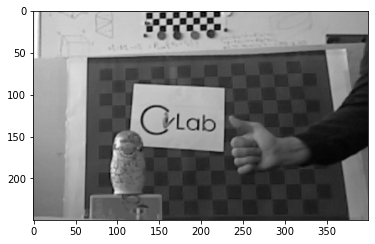

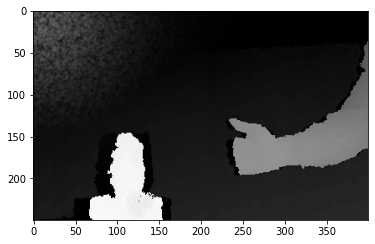

In [2]:
# Read the image 
img = cv2.imread('images/rgb.png',0)
depth_img = cv2.imread('images/depth_noisy.png',0)

# Display the images
plt.figure(1)
plt.imshow(img,cmap='gray')
plt.figure(2)
plt.imshow(depth_img,cmap='gray') 

depth_img = np.float64(depth_img)*4; # rescaled for better results 

## Exercise 1: Depth-based Segmentation

To start with, You are asked to implement the fucntion ```labelImage = clusterImage(depthImage,max_iters)``` by the following the steps below:
* $\forall pixels[i, j]: 0 ≤ i < H, 0 ≤ j < W$ of the depth image, compute the Euclidean
distance between its depth $D[i,j]$ and each cluster mean depth $k^l_d$: $dist[i,j,l] = \sqrt{(D[i,j] - {k^{l}}_{d})^2}$ and $l = 0,1,2$. How would you initialize cluster means?
* For each pixel find the smallest distance and assign this pixel to the
corresponding cluster.
* Compute the new mean of each cluster.
* Iterate over the above two steps till the cluster centroids (mean of the clusters) do not move any more or a fixed number of iterations is reached.

What issues do you observe in the output?

#### Inputs:

- ```depthImage```: an image where each value indicates the depth of the corresponding pixel.
- ```max_iters```: the maximum number of iterations 

#### Outputs:

- ```labelImage```:  output label image where each value indicates to which cluster the corresponding pixels belongs. There are three clusters: value 0 for the background, value 1 for the hand and value 2 for the doll.

Centroids are already initialized but if not, I wpould have initialize them randomly but with different random initialization and then take the smallest resulting cost.

1


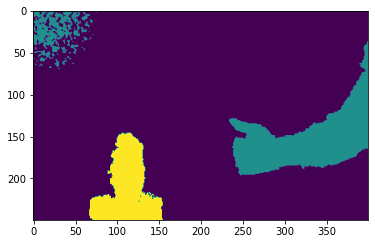

In [40]:
def clusterImage(depthImage, max_iters):
    
    k = 3 # Number of clusters 
    #initiate centroids
    #we create 3 centroids, in the format [Z X Y], where Z in the inverse depth
    mu = np.zeros((k,3)) 
    mu[0,:] = [0, 0, 0] #background centroid
    mu[1,:] = [500, 300, 150] #hand centroid
    mu[2,:] = [1000, 100, 200] #doll centroid
    # Note: For Exercise 1, only Z (inverse) depth is used. X,Y is used in Exercise 2.
    cluster_assignments = np.zeros(depthImage.shape)
    old_mu = mu+100
    epsilon = 0
    iter=0
    while ((iter < max_iters) and (np.sum((old_mu - mu)>epsilon)))  :  
        for i in range(depthImage.shape[0]):
            for j in range(depthImage.shape[1]) :
                #For each pixel find the smallest distance and assign this pixel to the corresponding cluster.
                dist = np.sqrt(np.square(depthImage[i,j]-mu[:,0]))
                cluster_assignments[i,j]=np.argmin(dist)
        #Compute the new mean of each cluster.
        old_mu = mu
        mu[0,0] = np.mean(depthImage[cluster_assignments==0])
        mu[1,0] = np.mean(depthImage[cluster_assignments==1])
        mu[2,0] = np.mean(depthImage[cluster_assignments==2])
        #Iterate over the above two steps till the cluster centroids (mean of the clusters) do not move any more or a fixed number of iterations is reached.    
        iter+=1
        print(iter)
    return cluster_assignments


cluster_assignments = clusterImage(depth_img,50)   
plt.imshow(cluster_assignments)

We obtain a good result with one iteration because the initial conditions were optimal. 

## Exercise 2: Using Location Information
As you saw in the previous exercise, sometimes the depth information is not enough to correctly segment the image. This can be fixed by taking into account also the spatial proximity of the pixels - pixels from the same cluster should be close to each other in the image. This can be
accomplished by adding 2 dimensions to the original depth image representing the i and
j coordinates of each pixel.

You are asked to implement a new function ```labelImage = clusterImage(depthImage,max_iters)``` following the steps:
* $\forall pixels[i, j]: 0 ≤ i < H, 0 ≤ j < W$ of the depth image, compute the Euclidean
distance between its combined depth $D[i,j]$ and position $[i,j]$ and each cluster mean $[k^l_d,k^l_i,k^l_j]$: $dist[i,j,l] = \sqrt{(D[i,j] - {k^{l}}_{d})^2 + (i-k^{l}_{i})^2) + (j-k^{l}_{j})^2)}$ for $l = 0,1,2$. 

* For each pixel find the smallest distance and assign this pixel to the
corresponding cluster.
* Compute the new mean of each cluster.
* Iterate over the above two steps till the cluster centroids (mean of the clusters)
do not move any more or a fixed number of iterations is reached.

How does addition of spatial information improve the segmentation results?

#### Inputs:

- ```depthImage```: an image where each value indicates the depth of the corresponding pixel.
- ```max_iters```: maximum number of iterations

#### Outputs:

- ```labelImage```:  output label image where each value indicates to which cluster the corresponding pixels belongs. There are three clusters: value 0 for the background, value 1 for the hand and value 2 for the doll.

1


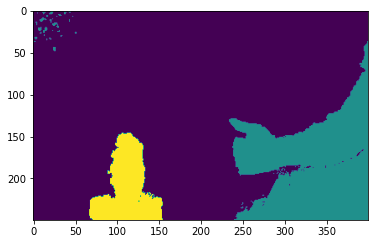

In [45]:
def clusterImage(depthImage, max_iters):
    
    k = 3 # Number of clusters 
    #initiate centroids
    #we create 3 centroids, in the format [Z X Y], where Z in the inverse depth
    mu = np.zeros((k,3)) 
    mu[0,:] = [0, 0, 0] #background centroid
    mu[1,:] = [500, 300, 150] #hand centroid
    mu[2,:] = [1000, 100, 200] #doll centroid
    
    # Code here
    
    #∀𝑝𝑖𝑥𝑒𝑙𝑠[𝑖,𝑗]:0≤𝑖<𝐻,0≤𝑗<𝑊  of the depth image, compute the Euclidean distance between its combined depth  𝐷[𝑖,𝑗]  and position  [𝑖,𝑗]  and each cluster mean  [𝑘𝑙𝑑,𝑘𝑙𝑖,𝑘𝑙𝑗] : 𝑑𝑖𝑠𝑡[𝑖,𝑗,𝑙]=(𝐷[𝑖,𝑗]−𝑘𝑙𝑑)2+(𝑖−𝑘𝑙𝑖)2)+(𝑗−𝑘𝑙𝑗)2)  for  𝑙=0,1,2 .
    #For each pixel find the smallest distance and assign this pixel to the corresponding cluster.
    #Compute the new mean of each cluster.
    #Iterate over the above two steps till the cluster centroids (mean of the clusters) do not move any more or a fixed number of iterations is reached.
    cluster_assignments = np.zeros(depthImage.shape)
    old_mu = mu+100
    epsilon = 0
    iter=0
    X, Y = np.meshgrid(np.arange(0, depthImage.shape[1]),np.arange(0, depthImage.shape[0]))
    dist = [None] * 3 
    while ((iter < max_iters) and (np.sum((old_mu - mu)>epsilon)))  :  
        for k_id in range(3): 
            dist[k_id] = np.sqrt(np.square(depthImage - mu[k_id,0])+ np.square(X-mu[k_id,1]) + np.square(Y-mu[k_id,2]))
        cluster_assignments = np.argmin(np.array(dist),axis=0) 
        #Compute the new mean of each cluster.
        old_mu = mu
        mu[0,:] = np.array([np.mean(depthImage[cluster_assignments==0]), np.mean(X[cluster_assignments==0]), np.mean(Y[cluster_assignments==0])])
        mu[1,:] = np.array([np.mean(depthImage[cluster_assignments==1]), np.mean(X[cluster_assignments==1]), np.mean(Y[cluster_assignments==1])])
        mu[2,:] = np.array([np.mean(depthImage[cluster_assignments==2]), np.mean(X[cluster_assignments==2]), np.mean(Y[cluster_assignments==2])])
        #Iterate over the above two steps till the cluster centroids (mean of the clusters) do not move any more or a fixed number of iterations is reached.    
        iter+=1
        print(iter)
    
    return cluster_assignments
    
cluster_assignments = clusterImage(depth_img,50)   
plt.imshow(cluster_assignments)

## Exercise 3: Image Sharpening

We further need to implement a region-based filtering function to sharpen the object of interest and blur the rest of 
the image. In the previous parts you produced a label image (with each object assigned a different label) and produced three binary images corresponding to different objects. Now the task is to sharpen the focused regions by applying a Laplacian filter and smooth the other regions using a Gaussian filter. It should produce results as shown below.

To this end we introduce a Laplacian filter parametrized by $\alpha$ defined as:

\begin{align}
L = \frac{\partial ^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} = \frac{4}{\alpha+1} \begin{bmatrix} \frac{\alpha}{4} & \frac{1-\alpha}{4} & \frac{\alpha}{4} \\
\frac{1-\alpha}{4} & -1 & \frac{1-\alpha}{4} \\
\frac{\alpha}{4} & \frac{1-\alpha}{4} & \frac{\alpha}{4} \\
\end{bmatrix}
\end{align}

Then, the sharpening filter is defined as $\delta - L$, where $\delta$ is a $3\times3$ Kronecker delta kernel with a values of 1 at the center position and zero elsewhere. The Gaussian kernel is parametrized by standard deviation $\sigma$.


* Implement functions 
``` s = SharpeningKernel(alpha) ``` and ``` g = GaussianKernel(sigma, sz)``` that compute sharpening filter of size $3\times3$ and gaussian kernel of size $sz\times sz$ respectively (you computed gaussian kernel already in Exercise Session 2).

In [50]:
def SharpeningKernel(alpha):
    delta = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
    L = 4/(1+alpha) * np.array([[alpha/4, (1-alpha)/4, alpha/4],[(1-alpha)/4, -1, (1-alpha)/4],[alpha/4, (1-alpha)/4, alpha/4]])
    s = delta-L
    return s

def GaussianKernel(sigma,sz):
    x, y = np.mgrid[-sz//2 + 1:sz//2 + 1, -sz//2 + 1:sz//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    g = g/g.sum()
    
    return g

* Implement a function ``` filteredImage = FilterRegions(origImage,binaryForeground, alpha, sigma)``` that smooths the background and sharpens the objects in the foreground.

#### Outputs:
* ```filteredImage``` - original image with sharpened foreground and smoothed background

#### Inputs:
* ```origImage``` - original image
* ```binaryForeground``` - binary mask with foreground pixels value equal to 1
* ```alpha``` - sharpening parameter
* ```sigma``` - smoothing parameter

In [51]:
def FilterRegions(origImage,binaryForeground, alpha, sigma,sz):

    gaussianImage = conv.convolve2d(origImage, GaussianKernel(sigma,sz), mode='same')
    sharpImage = conv.convolve2d(origImage, SharpeningKernel(alpha), mode='same')
    
    filteredImage=origImage.copy()
    filteredImage[binaryForeground==1] = sharpImage[binaryForeground==1]
    filteredImage[binaryForeground==0] = gaussianImage[binaryForeground==0]
    
    return filteredImage

* Visualize 3 images by focusing on different objects detected in the image. Use sharpnening filter of size $3\times3$ and $\alpha = 0.5$ and Gaussian kernel of size $7\times7$ and $\sigma = 2.0$.

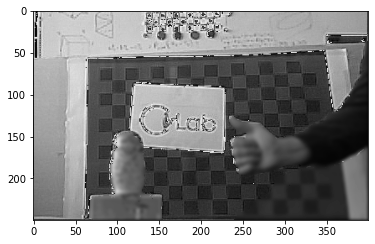

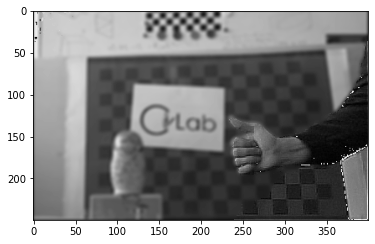

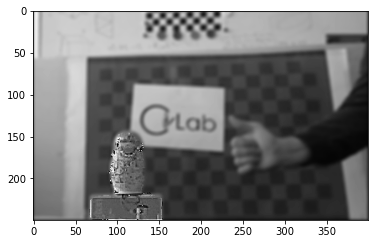

In [52]:
for i in range(3):
    binaryImg = cluster_assignments==i
    filteredImg = FilterRegions(img,binaryImg, 0.5,2,7)
    plt.figure()
    plt.imshow(filteredImg,cmap='gray')